In [1]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://financedata.github.io/posts/finance-data-reader-users-guide.html 
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import FinanceDataReader as fdr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
# http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020103
dataset = fdr.DataReader('005930', '2017', '2022')
dataset.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2017-01-02,35980,36240,35880,36100,93012,0.001665
2017-01-03,36280,36620,36020,36480,147153,0.010526
2017-01-04,36500,36520,36100,36160,159435,-0.008772
2017-01-05,36060,36060,35540,35560,219349,-0.016593
2017-01-06,36180,36440,36040,36200,177619,0.017998


In [5]:
df_stock = dataset[['Open', 'High', 'Low', 'Close']]
df_stock.head()

,Open,High,Low,Close
Date,,,,
2017-01-02,35980,36240,35880,36100
2017-01-03,36280,36620,36020,36480
2017-01-04,36500,36520,36100,36160
2017-01-05,36060,36060,35540,35560
2017-01-06,36180,36440,36040,36200


In [6]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df['High'].values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df

df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

In [7]:
df_stock_norm.head()

,Open,High,Low,Close
Date,,,,
2017-01-02,0.398450,0.374380,0.400894,0.009740
2017-01-03,0.401772,0.378306,0.402458,0.016595
2017-01-04,0.404208,0.377273,0.403352,0.010823
2017-01-05,0.399336,0.372521,0.397095,0.000000
2017-01-06,0.400664,0.376446,0.402682,0.011544


In [8]:
valid_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

In [9]:
def load_data(stock, seq_len):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])
    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1, :]
    x_test = data[train_set_size + valid_set_size:, :-1, :]
    y_test = data[train_set_size + valid_set_size:, -1, :]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ', x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (967, 19, 4)
y_train.shape =  (967, 4)
x_valid.shape =  (121, 19, 4)
y_valid.shape =  (121, 4)
x_test.shape =  (121, 19, 4)
y_test.shape =  (121, 4)


In [10]:
n_steps = seq_len -1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.compat.v1.reset_default_graph()

x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [11]:
from numpy.lib.index_tricks import index_exp
index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)
        start = 0
        index_in_epoch = batch_size
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [12]:
### RNN ### 
layers = [tf.contrib.rnn.BasicRNNCell(num_units = n_neurons, activation = tf.nn.elu)
          for layer in range(n_layers)]  

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [13]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps - 1, :]

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.


In [17]:
loss = tf.reduce_mean(tf.square(outputs - y))

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs * train_set_size / batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)
        sess.run(training_op, feed_dict = {x: x_batch, y: y_batch})
        if iteration % int(5*train_set_size / batch_size) == 0:
            mse_train = loss.eval(feed_dict = {x: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict = {x: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f' %(
                iteration * batch_size / train_set_size, mse_train, mse_valid))
    y_test_pred = sess.run(outputs, feed_dict = {x: x_test})

0.00 epochs: MSE train/valid = 0.703249/1.543437
4.96 epochs: MSE train/valid = 0.001292/0.003027
9.93 epochs: MSE train/valid = 0.001003/0.001875
14.89 epochs: MSE train/valid = 0.000783/0.001130
19.86 epochs: MSE train/valid = 0.000874/0.000732
24.82 epochs: MSE train/valid = 0.000674/0.001147
29.78 epochs: MSE train/valid = 0.000578/0.000557
34.75 epochs: MSE train/valid = 0.000539/0.000530
39.71 epochs: MSE train/valid = 0.000588/0.000839
44.67 epochs: MSE train/valid = 0.000534/0.000436
49.64 epochs: MSE train/valid = 0.000473/0.000349
54.60 epochs: MSE train/valid = 0.000456/0.000347
59.57 epochs: MSE train/valid = 0.000484/0.000544
64.53 epochs: MSE train/valid = 0.000474/0.000636
69.49 epochs: MSE train/valid = 0.000491/0.000438
74.46 epochs: MSE train/valid = 0.000425/0.000323
79.42 epochs: MSE train/valid = 0.000467/0.000418
84.38 epochs: MSE train/valid = 0.000433/0.000308
89.35 epochs: MSE train/valid = 0.000448/0.000371
94.31 epochs: MSE train/valid = 0.000423/0.000288
99.

In [20]:
y_test_pred.shape

(121, 4)

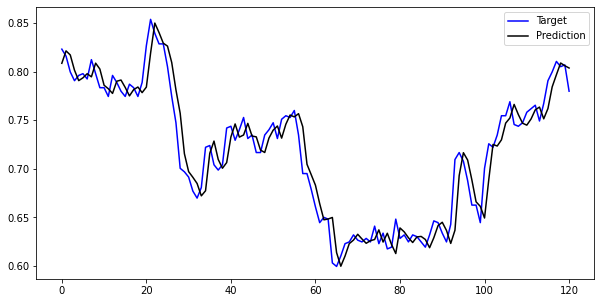

In [21]:
comp = pd.DataFrame({'Column1': y_test[:, 3], 'Column2': y_test_pred[:, 3]})
plt.figure(figsize = (10, 5))
plt.plot(comp['Column1'], color = 'blue', label = 'Target')
plt.plot(comp['Column2'], color = 'black', label = 'Prediction')
plt.legend()
plt.show()

In [22]:
### LSTM ### 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units = n_neurons, activation = tf.nn.elu)
          for layer in range(n_layers)]

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [24]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps - 1, :]

In [25]:
loss = tf.reduce_mean(tf.square(outputs - y))

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs * train_set_size / batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)
        sess.run(training_op, feed_dict = {x: x_batch, y: y_batch})
        if iteration % int(5*train_set_size / batch_size) == 0:
            mse_train = loss.eval(feed_dict = {x: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict = {x: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f' %(
                iteration * batch_size / train_set_size, mse_train, mse_valid))
    y_test_pred = sess.run(outputs, feed_dict = {x: x_test})

0.00 epochs: MSE train/valid = 0.128771/0.442924
4.96 epochs: MSE train/valid = 0.001441/0.002321
9.93 epochs: MSE train/valid = 0.001385/0.008533
14.89 epochs: MSE train/valid = 0.001716/0.003583
19.86 epochs: MSE train/valid = 0.001180/0.004880
24.82 epochs: MSE train/valid = 0.001252/0.010048
29.78 epochs: MSE train/valid = 0.000996/0.003043
34.75 epochs: MSE train/valid = 0.001112/0.000775
39.71 epochs: MSE train/valid = 0.001048/0.000909
44.67 epochs: MSE train/valid = 0.000844/0.002142
49.64 epochs: MSE train/valid = 0.000783/0.001339
54.60 epochs: MSE train/valid = 0.000797/0.001141
59.57 epochs: MSE train/valid = 0.000700/0.001394
64.53 epochs: MSE train/valid = 0.000710/0.003213
69.49 epochs: MSE train/valid = 0.000615/0.001330
74.46 epochs: MSE train/valid = 0.000581/0.000926
79.42 epochs: MSE train/valid = 0.000596/0.000754
84.38 epochs: MSE train/valid = 0.000604/0.002028
89.35 epochs: MSE train/valid = 0.000672/0.000735
94.31 epochs: MSE train/valid = 0.000639/0.002055
99.

In [28]:
y_test_pred.shape

(121, 4)

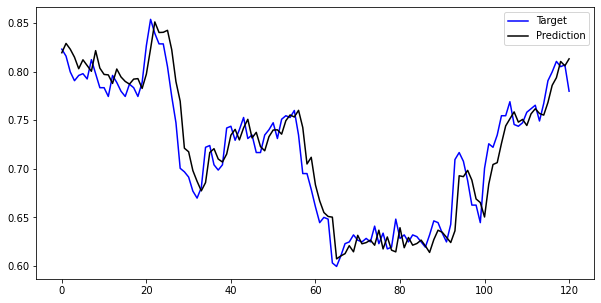

In [29]:
comp = pd.DataFrame({'Column1': y_test[:, 3], 'Column2': y_test_pred[:, 3]})
plt.figure(figsize = (10, 5))
plt.plot(comp['Column1'], color = 'blue', label = 'Target')
plt.plot(comp['Column2'], color = 'black', label = 'Prediction')
plt.legend()
plt.show()

In [30]:
### GRU ### 
layers = [tf.contrib.rnn.GRUCell(num_units = n_neurons, activation = tf.nn.leaky_relu)
          for layer in range(n_layers)]

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.


In [31]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, x, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps - 1, :]

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
loss = tf.reduce_mean(tf.square(outputs - y))

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

In [34]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs * train_set_size / batch_size)):
        x_batch, y_batch = get_next_batch(batch_size)
        sess.run(training_op, feed_dict = {x: x_batch, y: y_batch})
        if iteration % int(5*train_set_size / batch_size) == 0:
            mse_train = loss.eval(feed_dict = {x: x_train, y: y_train})
            mse_valid = loss.eval(feed_dict = {x: x_valid, y: y_valid})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f' %(
                iteration * batch_size / train_set_size, mse_train, mse_valid))
    y_test_pred = sess.run(outputs, feed_dict = {x: x_test})

0.00 epochs: MSE train/valid = 0.201281/0.650675
4.96 epochs: MSE train/valid = 0.001366/0.002527
9.93 epochs: MSE train/valid = 0.001229/0.003203
14.89 epochs: MSE train/valid = 0.001280/0.007984
19.86 epochs: MSE train/valid = 0.001068/0.001977
24.82 epochs: MSE train/valid = 0.001087/0.003423
29.78 epochs: MSE train/valid = 0.000832/0.000751
34.75 epochs: MSE train/valid = 0.000666/0.000893
39.71 epochs: MSE train/valid = 0.000691/0.001290
44.67 epochs: MSE train/valid = 0.000557/0.000498
49.64 epochs: MSE train/valid = 0.000567/0.001657
54.60 epochs: MSE train/valid = 0.000487/0.000769
59.57 epochs: MSE train/valid = 0.000456/0.001339
64.53 epochs: MSE train/valid = 0.000401/0.001325
69.49 epochs: MSE train/valid = 0.000391/0.000751
74.46 epochs: MSE train/valid = 0.000381/0.000707
79.42 epochs: MSE train/valid = 0.000421/0.001530
84.38 epochs: MSE train/valid = 0.000403/0.000795
89.35 epochs: MSE train/valid = 0.000458/0.002189
94.31 epochs: MSE train/valid = 0.000381/0.000743
99.

In [35]:
y_test_pred.shape

(121, 4)

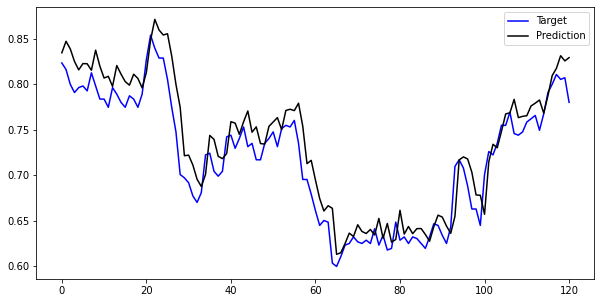

In [36]:
comp = pd.DataFrame({'Column1': y_test[:, 3], 'Column2': y_test_pred[:, 3]})
plt.figure(figsize = (10, 5))
plt.plot(comp['Column1'], color = 'blue', label = 'Target')
plt.plot(comp['Column2'], color = 'black', label = 'Prediction')
plt.legend()
plt.show()